# K-Nearest Neighbors for Regression

We'll use a data set for predicting the quality (log-price) of Bordeaux wines.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

In [ ]:
data_dir = "https://dlsun.github.io/pods/data/"
bordeaux_df = pd.read_csv(data_dir + "bordeaux.csv",
                          index_col="year")

# Split the data into training and test sets.
bordeaux_train = bordeaux_df.loc[:1980].copy()
bordeaux_test = bordeaux_df.loc[1981:].copy()

# Log transform the target.
bordeaux_train["log(price)"] = np.log(bordeaux_train["price"])
bordeaux_train.head()

,price,summer,har,sep,win,age,log(price)
year,,,,,,,
1952,37.0,17.1,160,14.3,600,40,3.610918
1953,63.0,16.7,80,17.3,690,39,4.143135
1955,45.0,17.1,130,16.8,502,37,3.806662
1957,22.0,16.1,110,16.2,420,35,3.091042
1958,18.0,16.4,187,19.1,582,34,2.890372


Let's focus on just two predictors for now: winter rainfall (**win**) and average summer temperature (**summer**). Let's plot the training data, using a color gradient to represent the target (**log(price)**).

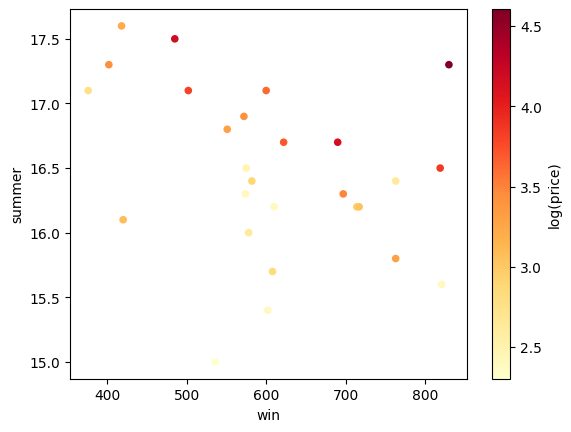

In [ ]:
import matplotlib.cm as cm

bordeaux_train.plot.scatter(x="win", y="summer", c="log(price)",
                            cmap=cm.YlOrRd);

Notice how wines that are close on this scatterplot are of similar quality. This insight is the basis of the $k$-nearest neighbors algorithm for predicting wine quality. Suppose that we want to predict the quality of the 1986 vintage, represented by a blue star in the plot below.

![](https://github.com/dlsun/pods/blob/master/05-Regression-Models/regression_neighbors.png?raw=1)

The $k=5$ points that are closest to this point in feature space are indicated by dotted lines. We can average the qualities of thse wines to obtain our prediction. All 5 of these points have a quality less than 3.0, so the 1986 vintage is also predicted to be of low quality.

The $k$-nearest neighbors regression algorithm can be summarized as follows:

1. Determine the $k$ closest points in the training data to the new point that you want to predict for, based on some distance metric on the features. Remember that when computing distance between observations we typically scale the features first (e.g., standarize, min/max).
2. The predicted label of the new point is the mean (or median) of the labels of the $k$ closest points.

Let's implement this in code. First, we extract the training data and scale the features:

In [ ]:
X_train = bordeaux_train[["win", "summer"]]
y_train = bordeaux_train["log(price)"]

# Standardize the features.
X_train_mean = X_train.mean()
X_train_sd = X_train.std()
X_train_st = (X_train - X_train_mean) / X_train_sd

X_train_st.head()

,win,summer
year,,
1952,-0.065156,0.965533
1953,0.632329,0.352135
1955,-0.824640,0.965533
1957,-1.460127,-0.567960
1958,-0.204653,-0.107912


Now, we get the features for the new observation (i.e., the 1986 vintage), standardizing it in the same way.

In [ ]:
x_new = bordeaux_test.loc[1986, ["win", "summer"]]

x_new_st = (x_new - X_train_mean) / X_train_sd
x_new_st

,0
win,-0.351900
summer,-0.261262


Now we calculate the (Euclidean) distances between the 1986 vintage and the vintages in the training data.

In [ ]:
dists = np.sqrt(((X_train_st - x_new_st) ** 2).sum(axis=1))
dists

,0
year,
1952,1.259860
1953,1.159726
1955,1.314727
1957,1.149883
1958,0.212597
1959,1.936933
1960,1.557535
1961,2.575503
1962,1.038478


Now, we sort the distances. The first 5 of these are the nearest neighbors. To get the year of these nearest neighbors, we get the index.

In [ ]:
i_nearest = dists.sort_values().index[:5]
i_nearest

Index([1974, 1958, 1969, 1968, 1980], dtype='int64', name='year')

We can look up these years in the training data.

In [ ]:
bordeaux_train.loc[i_nearest]

,price,summer,har,sep,win,age,log(price)
year,,,,,,,
1974,11.0,16.3,184,16.2,574,18,2.397895
1958,18.0,16.4,187,19.1,582,34,2.890372
1969,12.0,16.5,244,16.6,575,23,2.484907
1968,11.0,16.2,292,16.4,610,24,2.397895
1980,14.0,16.0,74,18.4,578,12,2.639057


To make a prediction for the price of the 1986 vintage, we average the sale prices of these 5-nearest neighbors.

In [ ]:
y_train.loc[i_nearest].mean()

np.float64(2.562025256579233)

So the model predicts that the quality of the 1986 is about 2.56, which is well below the average quality.

Of course, the model above only had two features so it was easy to visualize the "nearest neighbors" on the scatterplot. The magic of $k$-nearest neighbors is that it still works when there are more features and the data is not possible to visualize.

## K-Nearest Neighbors in scikit-learn


In [ ]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
          StandardScaler(),
          KNeighborsRegressor(n_neighbors=5)
)

pipeline.fit(X=X_train, y=y_train)
pipeline.predict(X=pd.DataFrame([x_new]))

array([2.56202526])

# Distances between Observations

How do we quantify how "similar" two observations are?

We will use the Ames housing data set as an example, but to keep things simple, we will work with just three quantitative variables from that data set: the number of bedrooms, the number of bathrooms, and the living area (in square feet).

In [ ]:
df_housing = pd.read_csv("https://raw.githubusercontent.com/kevindavisross/data301/main/data/AmesHousing.txt", sep="\t")
df_housing["Bathrooms"] = df_housing["Full Bath"] + df_housing["Bsmt Full Bath"] + 0.5 * (df_housing["Half Bath"] + df_housing["Bsmt Half Bath"])
df_housing_quant = df_housing[["Bedroom AbvGr", "Gr Liv Area", "Bathrooms"]]
df_housing_quant

,Bedroom AbvGr,Gr Liv Area,Bathrooms
0,3,1656,2.0
1,2,896,1.0
2,3,1329,1.5
3,3,2110,3.5
4,3,1629,2.5
...,...,...,...
2925,3,1003,2.0
2926,2,902,2.0
2927,3,970,1.5
2928,2,1389,2.0


Shown below is a (three-dimensional) scatterplot of these variables. Consider the two observations connected by a red line. (The label next to each point is its index in the `DataFrame`.) To measure how similar they are, we can calculate the distance between the two points.

![](https://github.com/dlsun/pods/blob/master/03-Quantitative-Data/distance.png?raw=1)

Calculating the distance between two points is not as straightforward as it might seem because there is more than one way to define distance. The most familiar distance metric is probably _Euclidan distance_, which is the straight-line distance ("as the crow flies") between the two points. The formula for calculating this distance is a generalization of the Pythagorean theorem:

$$ d({\bf x}, {\bf x'}) = \sqrt{\sum_{j=1}^D (x_j - x'_j)^2} $$



In [ ]:
x = df_housing_quant.loc[2927]
x

,2927
Bedroom AbvGr,3.0
Gr Liv Area,970.0
Bathrooms,1.5


In [ ]:
x1 = df_housing_quant.loc[2928]
x1

,2928
Bedroom AbvGr,2.0
Gr Liv Area,1389.0
Bathrooms,2.0


In [ ]:
x - x1

,0
Bedroom AbvGr,1.0
Gr Liv Area,-419.0
Bathrooms,-0.5


In [ ]:
(x - x1) ** 2

,0
Bedroom AbvGr,1.00
Gr Liv Area,175561.00
Bathrooms,0.25


In [ ]:
((x - x1) ** 2).sum()

np.float64(175562.25)

In [ ]:
np.sqrt(((x - x1) ** 2).sum())

np.float64(419.0014916441229)

The beauty of this definition is that it generalizes to more than three dimensions. Even though it is difficult to visualize points in 100-dimensional space, we can calculate distances between them in exactly the same way.

However, Euclidean distance is not the only way to measure how far apart two points are. There is also [**Manhattan distance**](https://en.wikipedia.org/wiki/Taxicab_geometry) (also called _taxicab distance_), which measures the distance a taxicab in Manhattan would have to drive to travel from A to B. In Manhattan, taxicabs cannot travel in a straight line (i.e., the green path below) because they have to follow the street grid. But there are multiple paths along the street grid that all have exactly the same length (i.e., the red, yellow, and blue paths below); the Manhattan distance is the length of any one of these shortest paths.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Manhattan_distance.svg/283px-Manhattan_distance.svg.png)

The formula for Manhattan distance is actually quite similar to the formula for Euclidean distance. Instead of squaring the differences and taking the square root at the end (as in Euclidean distance), we simply take absolute values:
$$ d({\bf x}, {\bf x'}) = \sum_{j=1}^D |x_j - x'_j|. $$

The following code calculates Manhattan distance:

In [ ]:
((x - x1).abs()).sum()

np.float64(420.5)

### Comparison of Euclidean and Manhattan distance

The Euclidean distance was essentially just the largest difference. This is because Euclidean distance first _squares_ the differences. The squaring operation has a "rich get richer" effect; larger values get magnified by more than smaller values. As a result, the largest differences tend to dominate the Euclidean distance.

On the other hand, Manhattan distance treats all differences equally. So Manhattan distance is preferred if we are concerned that an outlier in one variable might dominate the distance metric.

## The Importance of Scaling

Here's something to ponder. There are two pairs of observations in the figure below, one connected by a red line, the other connected by an orange line. Which pair of observations is more similar (assuming we use Euclidean distance)?

![](https://github.com/dlsun/pods/blob/master/03-Quantitative-Data/closer.png?raw=1)

Let's actually calculate these two distances.

In [ ]:
# Distance between two points connected by red line
x = df_housing_quant.loc[2927]
x1 = df_housing_quant.loc[2928]

np.sqrt(((x - x1) ** 2).sum())

np.float64(419.0014916441229)

In [ ]:
# Distance between two points connected by orange line
x = df_housing_quant.loc[2498]
x1 = df_housing_quant.loc[290]

np.sqrt(((x - x1) ** 2).sum())

np.float64(5.0990195135927845)

Surprised by the answer? The scatterplot is deceiving because it automatically scales the variables to make the points fit on the same plot. In reality, the variables are on very different scales. The number of bedrooms and bathrooms range from 0 to 6, while living area is in the thousands. When variables are on such different scales, the variable with the largest variability will dominate the distance metric.

The plot below shows the same data, but with axes on the same scale. We can see that differences in the number of bedrooms and the number of bathrooms hardly matter at all; only the variability in the living area matters.

![](https://github.com/dlsun/pods/blob/master/03-Quantitative-Data/closer_rescaled.png?raw=1)

To obtain distances that agree more with our intuition---and that do not give too much weight to any one variable---we transform the variables to be on the same scale. There are several ways to _scale_ a variable ${\bf x} = (x_1, \ldots, x_n)$:

- _standardizing_: subtract each value by the mean, then divide by the standard deviation,
$$ x_i \leftarrow \frac{x_i - \bar {\bf x}}{\text{SD}({\bf x})} $$
- _normalizing_: scale each value so that the variable has length (or "norm") 1,
$$ x_i \leftarrow \frac{x_i}{\sqrt{\sum_{i=1}^n x_i^2}} $$
- _min/max scaling_: scale each value so that all values are between 0 and 1,
$$x_i \leftarrow \frac{x_i - \min({\bf x})}{\max({\bf x}) - \min({\bf x})}.$$

Warning: the terms "standardize" and "normalize" are also used to represent other things, so pay careful attention to context.


The figure below illustrates what each of these scaling methods do to a synthetic data set with two variables. All three methods scale the variables in similar (but slightly different) ways, resulting in figure-eights with different aspect ratios.  Standardizing also moves the data to be centered around the origin, while min-max scaling moves the data to be in a box whose corners are $(0, 0)$ and $(1, 1)$.

![](https://github.com/dlsun/pods/blob/master/03-Quantitative-Data/scaling.png?raw=1)

Let's standardize the Ames housing data, and see how it affects the distance metric.

In [ ]:
df_housing_st = (
    (df_housing_quant - df_housing_quant.mean()) /
    df_housing_quant.std()
)
df_housing_st

,Bedroom AbvGr,Gr Liv Area,Bathrooms
0,0.176064,0.309212,-0.269988
1,-1.032058,-1.194223,-1.509056
2,0.176064,-0.337661,-0.889522
3,0.176064,1.207317,1.588613
4,0.176064,0.255801,0.349546
...,...,...,...
2925,0.176064,-0.982555,-0.269988
2926,-1.032058,-1.182354,-0.269988
2927,0.176064,-1.047836,-0.889522
2928,-1.032058,-0.218968,-0.269988


Now let's recalculate the distances using this standardized data and see if our conclusions change.

In [ ]:
# Distance between two points connected by red line
x = df_housing_st.loc[2927]
x1 = df_housing_st.loc[2928]

np.sqrt(((x - x1) ** 2).sum())

np.float64(1.590723724183515)

In [ ]:
# Distance between two points connected by orange line
x = df_housing_st.loc[2498]
x1 = df_housing_st.loc[290]

np.sqrt(((x - x1) ** 2).sum())

np.float64(3.8303230350567894)

So, if we first standardize the data, then the pair of observations connected by the red line are more similar than the pair connected by the orange line, which matches our intuition. It is (almost) always a good idea to scale the variables before calculating distances.

## Visualizing K-Nearest Neighbors Regression Functions

A predictive model is simply a function $f$ that maps feature values ${\bf x}$ to target values $y$. We can visualize $f$ when ${\bf x}$ consists of just a single feature. We have seen that a linear regression function $f$ based on a single feature is a linear function of $x$. What does $f$ look like when the model is a $k$-nearest neighbors regressor?


### K-Nearest Neighbors Regression Functions for a Single Quantitative Feature: Wine Data


Recall the wines data set where our target is log(price), a proxy for quality.
We'll use a K-Nearest Neighbors model for predicting log(price) from a single feature, age.

First, we extract the training data. There is no need to scale the features in this case because there is only one feature. (The point of scaling is to bring all of the *feature* variables to the same scale before computing distances between observations.)

In [ ]:
bordeaux_df = pd.read_csv("https://dlsun.github.io/pods/data/bordeaux.csv",
                          index_col="year")

# Split the data into training and test sets
bordeaux_train = bordeaux_df.loc[:1980].copy()
bordeaux_test = bordeaux_df.loc[1981:].copy()

# Log transform the target
bordeaux_train["log(price)"] = np.log(bordeaux_train["price"])

# train on a single feature, age
X_train = bordeaux_train[["age"]]
y_train = bordeaux_train["log(price)"]

In [ ]:
bordeaux_train[["age", "log(price)"]].sort_values("age").head(5)

,age,log(price)
year,,
1980,12,2.639057
1979,13,3.044522
1978,14,3.295837
1977,15,2.397895
1976,16,3.218876


Let's make a scatterplot of the training data. Careful! In the reading, we made a scatterplot where both the x-axis and y-axis corresponded to *feature* variables (and the target corresponded to color). But now the x-axis is the feature and the y-axis is the target.

<Axes: xlabel='age', ylabel='log(price)'>

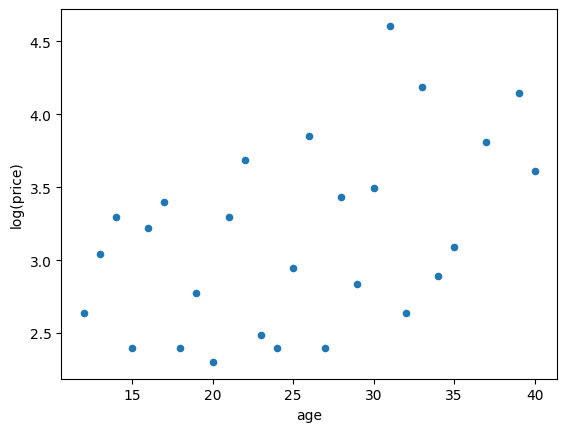

In [ ]:
bordeaux_train.plot.scatter(x="age", y="log(price)")

1. Consider a **1-nearest neighbor** regression model. Say we want to add the regression function to the scatterplot. Sketch a plot of what the regression function would look like. **Discuss with your partner before proceeding.** Hint: The smallest ages in the training data are 12, 13, 14, etc. What would the predicted price be for age = 12? age = 13? age = 11.5? age = 12.49? age = 12.51? age = 13.49? age = 13.51?

**Sketch on paper and discuss with your partner.**

2. Consider a **2-nearest neighbor** regression model. Say we want to add the regression function to the scatterplot. Sketch a plot of what the regression function would look like. **Discuss with your partner before proceeding.** Hint: The smallest ages in the training data are 12, 13, 14, etc. What would the predicted price be for age = 12? age = 12.99? age = 13.01? age = 13.99? age = 14.01?

**Sketch on paper and discuss with your partner.**

3. What would the 27-nearest neighbors regression function look like? **Discuss with your partner before proceeding.** Hint: what is special about 27 in this example?

**Sketch on paper and discuss with your partner.**

4. **Be sure to think about and discuss the previous questions before doing this part!** Now we'll fit some models and plot the regression function.  


<Axes: xlabel='age', ylabel='log(price)'>

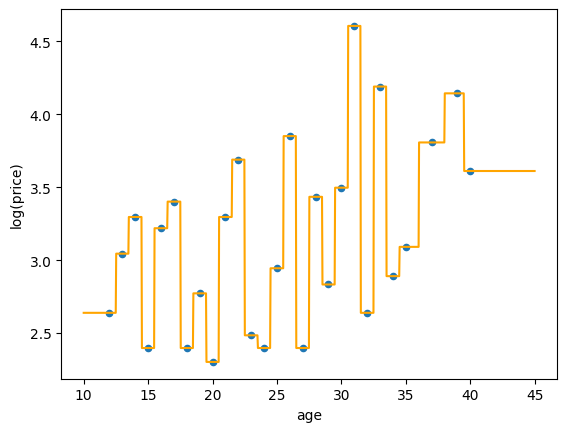

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Fit k-nearest neighbors
# ADD YOUR CODE HERE
model = KNeighborsRegressor(n_neighbors=1)
model.fit(X=X_train, y=y_train)

# Define a grid of feature values to make predictions for
X_new = pd.DataFrame()
X_new["age"] = np.linspace(10, 45, num=1000)

# Make predictions at those feature values.
y_new_ = pd.Series(
    # ADD YOUR CODE HERE,
    model.predict(X_new),
    index=X_new["age"]
)

# Plot the scatter plot and the predictions (regression function)
bordeaux_train.plot.scatter(x="age", y="log(price)")
y_new_.plot.line(color = "orange")


5. Now we'll fit a K-nearest neighbors regression model and plot the regression function for K=1, 2, 10, 27. The code below basically implements the code from the previous part for each of the values of K. Run the code and **discuss the output with your partner**. Do the regression functions look like what you expected? What happens as K increases?

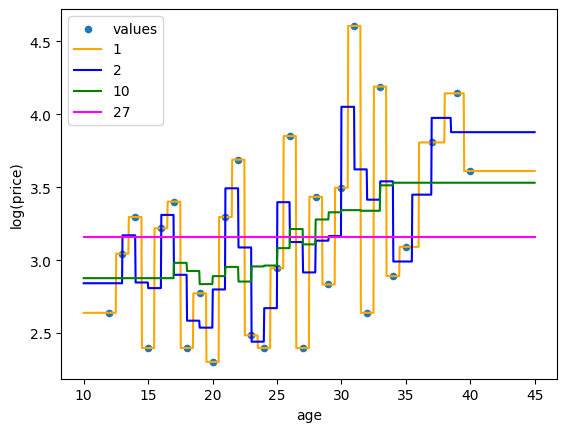

In [ ]:
import matplotlib.pyplot as plt

ks = [1, 2, 10, 27]
colors = ["orange", "blue", "green", "magenta", "black"]

bordeaux_train.plot.scatter(x="age", y="log(price)")

# Define a grid of feature values.
X_new = pd.DataFrame()
X_new["age"] = np.linspace(10, 45, num=1000)

for i in range(len(ks)):

  # Fit k-nearest neighbors
  model = KNeighborsRegressor(n_neighbors=ks[i])
  model.fit(X=X_train, y=y_train)

  # Make predictions at those feature values.
  y_new_ = pd.Series(
      model.predict(X_new),
      index=X_new["age"]
  )

  # Plot the predictions.
  y_new_.plot.line(color = colors[i])
  plt.legend(["values"] + ks);


### K-Nearest Neighbors Regression Functions for a Single Categorical Feature: Housing Data

Recall the Ames housing data set. We'll use a single categorical feature---Neighborhood---to predict SalePrice. How would 10-nearest neighbors behave?

Note: This is not an issue you would need to worry abotu in practice because you'll have both a number of both numerical and categorical features. But it's a good conceptual exercise.

### K-Nearest Neighbors Regression Functions for Two Quantitative Features: Sketching for Small Training Data

When there are multiple features, a regression function will be a surface in a higher dimensional space and is therefore difficult to visualize. Essentially the regression function splits the feature space into regions based on which $K$ points in the training data are closest, and makes constant predictions over these regions so that the regression surface has something like a ["log step"](https://i.pinimg.com/originals/f3/61/21/f36121c84fa42b6cad525f865d61d049.png) shape.

We'll sketch plots of the regression surface when there are two quantitative features and the training data only contains a few observations. Assume that the features have already been scaled and that Euclidean distance is used to determine nearest neighbors.

1. Consider **1-nearest neighbors** regression model based on two quantitative features which have already been scaled. Imagine the training data set only contains 2 observations. Skecth a plot of the regression function.  **Discuss with your partner.**

**Sketch on paper and discuss with your partner.**

2. Consider **1-nearest neighbors** regression model based on two quantitative features which have already been scaled. Imagine the training data set only contains 3 observations. Skecth a plot of the regression function.  **Discuss with your partner.**

**Sketch on paper and discuss with your partner.**

3. Consider **2-nearest neighbors** regression model based on two quantitative features which have already been scaled. Imagine the training data set only contains 3 observations. Skecth a plot of the regression function.  **Discuss with your partner.**

**Sketch on paper and discuss with your partner.**